In [1]:
import torch as th
from active_critic.learner.active_critic_learner import ActiveCriticLearner, ACLScores
from active_critic.learner.active_critic_args import ActiveCriticLearnerArgs
from active_critic.policy.active_critic_policy import ActiveCriticPolicy
from active_critic.utils.test_utils import setup_ac_reach
from active_critic.utils.gym_utils import make_dummy_vec_env, parse_sampled_transitions, sample_expert_transitions, DummyExtractor, new_epoch_reach, sample_new_episode
from active_critic.utils.pytorch_utils import make_part_obs_data
from active_critic.utils.dataset import DatasetAC
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from active_critic.utils.dataset import DatasetAC
from gym import Env
th.manual_seed(0)

/home/hendrik/anaconda3/envs/tfTest/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-10-10 17:43:30.105152: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/hendrik/anaconda3/envs/tfTest/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


2022-10-10 17:43:31.890552: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-10 17:43:31.890650: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-10 17:43:31.890743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 17:43:31.890865: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 7.92GiB deviceMemoryBandwidth: 298.32GiB/s
2022-10-10 17:43:31.890902: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-10 17:43:31.890936: I tensorflow/stream_executor/platform/d

1 Physical GPUs, 1 Logical GPUs
log dir: /home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/gboard/test_acl/train/


/home/hendrik/Documents/master_project/Code/active_critic/metaworld/metaworld/policies/policy.py:41: UserWarning: Constant(s) may be too high. Environments clip response to [-1, 1]
  warnings.warn('Constant(s) may be too high. Environments clip response to [-1, 1]')


Sampling expert transitions. 2


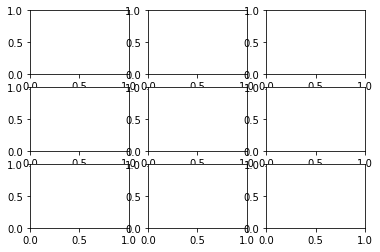

In [2]:
device = 'cuda'
acla = ActiveCriticLearnerArgs()
acla.data_path = '/home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/'
acla.device = device
acla.extractor = DummyExtractor()
acla.imitation_phase = False
acla.logname = 'test_acl'
acla.tboard = True
acla.batch_size = 32
acla.validation_episodes = 5
acla.val_every = 100
seq_len = 100
epsiodes = 2
ac, acps, env = setup_ac_reach(seq_len=seq_len)
acl = ActiveCriticLearner(ac_policy=ac, env=env, network_args_obj=acla)
env, expert = make_dummy_vec_env(name='reach', seq_len=seq_len)
transitions = sample_expert_transitions(policy=expert.predict, env=env, episodes=epsiodes)
exp_actions, exp_observations, exp_rewards = parse_sampled_transitions(transitions=transitions, new_epoch=new_epoch_reach, extractor=DummyExtractor(), device=device)
assert th.all(exp_rewards[:,-1]==1), 'Expert cant solve Environment.'

1 Physical GPUs, 1 Logical GPUs
log dir: /home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/gboard/test_acl/train/
Sampling expert transitions. 2


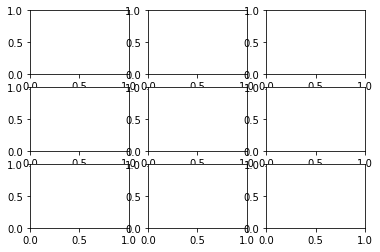

In [3]:
device = 'cuda'
acla = ActiveCriticLearnerArgs()
acla.data_path = '/home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/'
acla.device = device
acla.extractor = DummyExtractor()
acla.imitation_phase = True
acla.logname = 'test_acl'
acla.tboard = True
acla.batch_size = 32
acla.val_every = 100
acla.validation_episodes = 5
seq_len = 5
epsiodes = 2
ac, acps, env = setup_ac_reach(seq_len=seq_len)
acl = ActiveCriticLearner(ac_policy=ac, env=env, network_args_obj=acla)
env, expert = make_dummy_vec_env(name='reach', seq_len=seq_len)
transitions = sample_expert_transitions(policy=expert.predict, env=env, episodes=epsiodes)
exp_actions, exp_observations, exp_rewards = parse_sampled_transitions(transitions=transitions, new_epoch=new_epoch_reach, extractor=DummyExtractor(), device=device)

part_acts, part_obsv, part_rews = make_part_obs_data(actions=exp_actions, observations=exp_observations, rewards=exp_rewards)

for i in range(seq_len*epsiodes):
    org_index = int(i/seq_len)
    part_obs = th.clone(exp_observations[org_index])
    part_obs[i%seq_len + 1 :] = 0
    assert th.equal(part_acts[i], exp_actions[org_index]), 'make_part_obs_data corrupted'
    assert th.equal(part_obsv[i], part_obs), 'make_part_obs_data corrupted'
    

In [4]:
acl_scores = ACLScores()
acl_scores.update_min_score(acl_scores.mean_actor, 0)
assert acl_scores.mean_actor == [0]

In [5]:
actions, observations, rewards, expected_rewards_before, expected_rewards_after = sample_new_episode(
    policy=ac,
    env=env,
    episodes=1,)
assert list(actions.shape) == [1, seq_len, env.action_space.shape[0]]
assert list(observations.shape) == [1, seq_len, env.observation_space.shape[0]]
assert list(rewards.shape) == [1, seq_len, 1]
assert list(expected_rewards_after.shape) == [1, seq_len, 1]

Sampling expert transitions. 1


In [6]:
imitation_data = DatasetAC(device='cuda')
imitation_data.onyl_positiv = False
imitation_data.add_data(obsv=part_obsv, actions=part_acts, reward=part_rews)
assert len(imitation_data) == epsiodes * seq_len
assert list(imitation_data.actions.shape) == [epsiodes * seq_len, seq_len, env.action_space.shape[0]]
assert list(imitation_data.obsv.shape) == [epsiodes * seq_len, seq_len, env.observation_space.shape[0]]
assert list(imitation_data.reward.shape) == [epsiodes * seq_len, seq_len, 1]
imitation_data.onyl_positiv = True
assert len(imitation_data) == 0

In [7]:
imitation_data.onyl_positiv = False
dataloader = th.utils.data.DataLoader(imitation_data, batch_size=2*len(imitation_data))
for data in dataloader:
    dobsv, dact, drews = data
assert th.equal(dact, part_acts)
assert th.equal(dobsv, part_obsv)
assert th.equal(drews, part_rews)

In [8]:
imitation_data.add_data(obsv=part_obsv, actions=part_acts, reward=part_rews)
imitation_data.onyl_positiv = False
dataloader = th.utils.data.DataLoader(imitation_data, batch_size=2*len(imitation_data))
for data in dataloader:
    dobsv, dact, drews = data
assert list(dobsv.shape) == [2*epsiodes * seq_len, seq_len, env.observation_space.shape[0]]
assert list(dact.shape) == [2*epsiodes * seq_len, seq_len, env.action_space.shape[0]]
assert list(drews.shape) == [2*epsiodes * seq_len, seq_len, 1]


In [9]:
acl.setDatasets(train_data=imitation_data)

In [10]:
acl.policy.args_obj.device

'cuda'

In [15]:
acl.train(epochs=800)
assert acl.scores.mean_actor[0] < 1e-3
assert acl.scores.mean_critic[0] < 1e-3

Sampling expert transitions. 5
Sampling expert transitions. 5
Sampling expert transitions. 5
Sampling expert transitions. 5
Sampling expert transitions. 5
Sampling expert transitions. 5
Sampling expert transitions. 5
Sampling expert transitions. 5


In [16]:
acl.scores.mean_critic[0]

tensor(7.6284e-05, device='cuda:0')

In [ ]:
def make_acl():
        device = 'cuda'
        acla = ActiveCriticLearnerArgs()
        acla.data_path = '/home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/'
        acla.device = device
        acla.extractor = DummyExtractor()
        acla.imitation_phase = False
        acla.logname = 'test_acl'
        acla.tboard = False
        acla.batch_size = 32
        seq_len = 5
        epsiodes = 2
        ac, acps, env = setup_ac_reach(seq_len=seq_len)
        acl = ActiveCriticLearner(ac_policy=ac, env=env, network_args_obj=acla)
        env, expert = make_dummy_vec_env(name='reach', seq_len=seq_len)
        return acl, env, expert, seq_len, epsiodes, device

In [ ]:
acl, env, expert, seq_len, epsiodes, device = make_acl()

acl.add_training_data()
lenght_after = 0
for data in acl.train_loader:
    obsv, actions, reward = data
    lenght_after += len(obsv)
assert lenght_after == acl.policy.args_obj.epoch_len

Sampling expert transitions. 1


ValueError: too many values to unpack (expected 4)